<h2>目次 - Chapter 6</h2>

- [50. 文区切り](#prob50)
- [51. 単語の切り出し](#prob51)
- [52. ステミング](#prob52)
- [53. Tokenization](#prob53)
- [54. 品詞タグ付け](#prob54)
- [55. 固有表現抽出](#prob55)
- [56. 共参照解析](#prob56)
- [57. 係り受け解析](#prob57)
- [58. タプルの抽出](#prob58)
- [59. S式の解析](#prob59)

In [1]:
!cat ./data/nlp.txt 2>/dev/null | head

Natural language processing
From Wikipedia, the free encyclopedia

Natural language processing (NLP) is a field of computer science, artificial intelligence, and linguistics concerned with the interactions between computers and human (natural) languages. As such, NLP is related to the area of humani-computer interaction. Many challenges in NLP involve natural language understanding, that is, enabling computers to derive meaning from human or natural language input, and others involve natural language generation.

History

The history of NLP generally starts in the 1950s, although work can be found from earlier periods. In 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence.

The Georgetown experiment in 1954 involved fully automatic translation of more than sixty Russian sentences into English. The authors claimed that within three or five years, machine translation would b

<a name='prob50'></a>
# 50. 文区切り

(. or ; or : or ? or !) → 空白文字 → 英大文字というパターンを文の区切りと見なし，入力された文書を1行1文の形式で出力せよ．

間の空白にマッチさせる肯定後読み+肯定先読みでもできる -> (?<=[.;:?!\])\s+(?=[A-Z\]), 速いが見出し文も取れてしまう

In [8]:
import re

regex_sentence = re.compile(r'(?P<sentence>(.*?)[.;:?!])\s(?=[A-Z]|$)')

with open('./data/nlp.txt') as data, open('./work/sentences.txt', 'w') as out:
    print(*(match.group('sentence') for line in data for match in regex_sentence.finditer(line)), sep='\n', file=out)

In [9]:
!cat ./work/sentences.txt 2>/dev/null | head

Natural language processing (NLP) is a field of computer science, artificial intelligence, and linguistics concerned with the interactions between computers and human (natural) languages.
As such, NLP is related to the area of humani-computer interaction.
Many challenges in NLP involve natural language understanding, that is, enabling computers to derive meaning from human or natural language input, and others involve natural language generation.
The history of NLP generally starts in the 1950s, although work can be found from earlier periods.
In 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence.
The Georgetown experiment in 1954 involved fully automatic translation of more than sixty Russian sentences into English.
The authors claimed that within three or five years, machine translation would be a solved problem.
However, real progress was much slower, and after the ALPA

- assertion -> 簡易的に値をcheckできる

In [1]:
a = 1
assert a == 2
print(a)

AssertionError: 

標準入出力を使えるプログラムを書くのがよさそう(pipeが便利)<br>
parallelで並列処理?<br>
cat hogehoge.txt | parallel hoge.py | fuga.py > fugafuga.txt

<a name='prob51'></a>
# 51. 単語の切り出し

<h2>nltkとかspacyとか使おうよ</h2>

空白を単語の区切りとみなし，50の出力を入力として受け取り，1行1単語の形式で出力せよ．ただし，文の終端では空行を出力せよ．

In [2]:
with open('./work/sentences.txt') as data, open('./work/words.txt', 'w') as out:
    for line in data:
        for word in line.split():
            print(word.strip('.;:?!,"()'), file=out) # なんかいろいろ余分なの除いた
        print(file=out) # 1文の終端の処理(空文字列をprint->改行)

In [5]:
!cat ./work/words.txt 2>/dev/null | head

Natural
language
processing
NLP
is
a
field
of
computer
science


<a name='prob52'></a>
# 52. ステミング

51の出力を入力として受け取り，Porterのステミングアルゴリズムを適用し，単語と語幹をタブ区切り形式で出力せよ． 
Pythonでは，Porterのステミングアルゴリズムの実装としてstemmingモジュールを利用するとよい．

In [5]:
import itertools
from stemming.porter2 import stem

with open('./work/words.txt') as data:
    for line in itertools.islice(data, 10):
        word = line.strip() # \nを取る
        print(word, stem(word), sep='\t')

Natural	Natur
language	languag
processing	process
NLP	NLP
is	is
a	a
field	field
of	of
computer	comput
science	scienc


sep='\t'と{}\t{}.formatはどちらがいいか問題

<a name='prob53'></a>
# 53. Tokenization

Stanford Core NLPを用い，入力テキストの解析結果をXML形式で得よ．
また，このXMLファイルを読み込み，入力テキストを1行1単語の形式で出力せよ．

In [79]:
!/Users/r-fujii/Documents/stanford-corenlp-full-2018-02-27/corenlp.sh -annotators tokenize,ssplit,pos,lemma,ner,parse,depparse,dcoref -file ./data/nlp.txt

java -mx5g -cp "/Users/r-fujii/Documents/stanford-corenlp-full-2018-02-27/*" edu.stanford.nlp.pipeline.StanfordCoreNLP -annotators tokenize,ssplit,pos,lemma,ner,parse,depparse,dcoref -file ./data/nlp.txt
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
[main] INFO edu.stanford.nlp.ie.AbstractSequenceClassifier - Loading classifier from edu/stanfor

In [82]:
import itertools
import xml.etree.ElementTree as ET

tree = ET.parse('./work/nlp.txt.xml') # xmlを解析して要素の木にする
root = tree.getroot()

# root以下のtag='word'の要素をイテレート
for word in itertools.islice(root.iter('word'), 10): print(word.text)

Natural
language
processing
From
Wikipedia
,
the
free
encyclopedia
Natural


これはtreeをメモリに全乗せする? -> iterparseなるものがあるらしい
- xml.etree.ElementTree, lxml

<a name='prob54'></a>
# 54. 品詞タグ付け

Stanford Core NLPの解析結果XMLを読み込み，単語，レンマ，品詞をタブ区切り形式で出力せよ．

In [6]:
import itertools
import xml.etree.ElementTree as ET

tree = ET.parse('./work/nlp.txt.xml') # xmlを解析して要素の木にする
root = tree.getroot()

for token in itertools.islice(root.iter('token'), 10):
    print(token.find('word').text, token.find('lemma').text, token.find('POS').text, sep='\t')
    # ET.Element.find(match)はmatchにマッチする最初の子要素を返す

Natural	natural	JJ
language	language	NN
processing	processing	NN
From	from	IN
Wikipedia	Wikipedia	NNP
,	,	,
the	the	DT
free	free	JJ
encyclopedia	encyclopedia	NN
Natural	natural	JJ


- findall(.//hoge)はhoge以下の全要素を探す

<a name='prob55'></a>
# 55. 固有表現抽出

入力文中の人名をすべて抜き出せ．

In [7]:
import itertools
import xml.etree.ElementTree as ET

tree = ET.parse('./work/nlp.txt.xml')
root = tree.getroot()

tokens = (token for token in root.iter('token'))
gr = itertools.groupby(tokens, key = lambda x: x.find('NER').text == 'PERSON')
for is_name, items in gr:
    if is_name:
        print(' '.join(item.find('word').text for item in items))

Alan Turing
Joseph Weizenbaum
MARGIE
Schank
Wilensky
Meehan
Lehnert
Carbonell
Lehnert
Racter
Jabberwacky
Moore


dependency visualizer<br>
- spacy.displacy

固有表現はBIOタグ付けで解かれることが多い (Oがめちゃくちゃ多いからOに関してはlossを考えないなど...)

<a name='prob56'></a>
# 56. 共参照解析

Stanford Core NLPの共参照解析の結果に基づき，文中の参照表現（mention）を代表参照表現（representative mention）に置換せよ．
ただし，置換するときは，「代表参照表現（参照表現）」のように，元の参照表現が分かるように配慮せよ．

root.iterfind(.//coreference/coreference)で拾う方がsmart<br>
直接xml treeの中身の単語を書き換えちゃえばいいじゃん

In [1]:
import itertools
import xml.etree.ElementTree as ET

tree = ET.parse('./work/nlp.txt.xml')
root = tree.getroot()

sentences = {}
# 本文(corefを除いた部分)を取ってくる
for content in root.find('document').find('sentences'):
    for sentence in content.iter('sentence'):
        s_idx = sentence.attrib['id']
        
        tokens = {}
        for token in sentence.iter('token'):
            t_idx = token.attrib['id']
            tokens[t_idx] = token.find('word').text
            
        sentences[s_idx] = tokens

# 共参照に関する情報を取ってくる
for corefs in root.find('document').find('coreference'):
    for coref in corefs.iter('coreference'):
        for mention in coref.iter('mention'):
            if mention.get(key='representative'):
                representative = mention.find('text').text
            
            else:
                sentences[mention.find('sentence').text][mention.find('start').text] = \
                representative + ' ( ' + sentences[mention.find('sentence').text][mention.find('start').text]
                
                sentences[mention.find('sentence').text][mention.find('end').text] = \
                ') ' + sentences[mention.find('sentence').text][mention.find('end').text]

for _, sentence in itertools.islice(sentences.items(), 10):
    print(' '.join(token for token in sentence.values()))

Natural language processing From Wikipedia , the free encyclopedia Natural language processing -LRB- NLP -RRB- is the free encyclopedia Natural language processing -LRB- NLP -RRB- ( a field of computer science ) , artificial intelligence , and linguistics concerned with the interactions between computers and human -LRB- natural -RRB- languages .
As such , NLP is related to the area of humani-computer interaction .
Many challenges in NLP involve natural language understanding , that is , enabling computers ( computers ) to derive meaning from human or natural language input , and others involve natural language generation .
History The history of NLP generally starts in the 1950s , although work can be found from earlier periods .
In 1950 , Alan Turing published an article titled `` Computing Machinery and Intelligence '' which proposed what is now called the Alan Turing ( Turing ) test as a criterion of intelligence .
The Georgetown experiment in 1954 involved fully automatic translati

- **いやなんか、the free encyclopedia Natural language processing -LRB- NLP -RRB-がa field of computer scienceの代表表現とかなってるけど解析おかしくない?**

<a name='prob57'></a>
# 57. 係り受け解析

Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

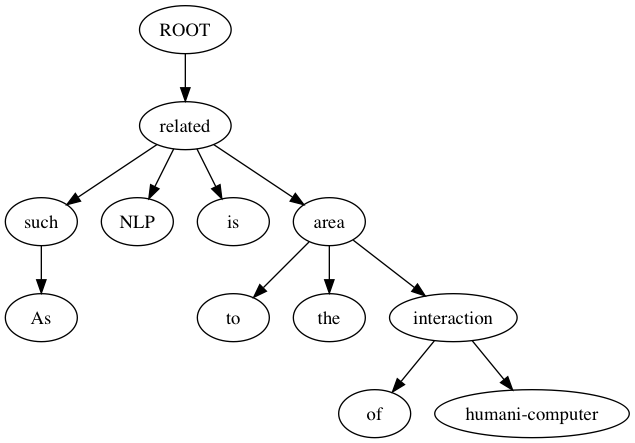

In [3]:
import xml.etree.ElementTree as ET
from cytoolz import nth
import pydot
from IPython.display import Image

def get_dep_trees(xml_tree):
    # xml_tree(root)を受け取ってその子要素にあるdependenciesから1文の係り受け木のDOT言語表現を返すジェネレータ

    head = '''
    digraph dep_tree{
     // edge define
    '''
    foot = '\n}'
    
    for deps in xml_tree.iter('dependencies'):
        if deps.attrib['type'] == 'collapsed-dependencies':
        
            dotex = head
        
            for dep in deps.iter('dep'):
                if not dep.attrib['type'] == 'punct':
                    dotex += '''\n {n1} [label = "{parent}"];
                             \n {n2} [label = "{child}"];
                             \n {n1} -> {n2};'''.format(n1=dep.find('governor').attrib['idx'] , n2=dep.find('dependent').attrib['idx'] ,\
                                                        parent=dep.find('governor').text, child=dep.find('dependent').text)
                    
            dotex += foot
            yield dotex

tree = ET.parse('./work/nlp.txt.xml')
root = tree.getroot()

dep_trees = get_dep_trees(root)

for graph in pydot.graph_from_dot_data(nth(1, dep_trees)):
    graph.write_png('./work/dep_tree.png')
    
Image('./work/dep_tree.png')

<a name='prob58'></a>
# 58. タプルの抽出

Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）に基づき，「主語 述語 目的語」の組をタブ区切り形式で出力せよ．ただし，主語，述語，目的語の定義は以下を参考にせよ．

- 述語: nsubj関係とdobj関係の子（dependant）を持つ単語
- 主語: 述語からnsubj関係にある子（dependent）
- 目的語: 述語からdobj関係にある子（dependent）

In [10]:
import xml.etree.ElementTree as ET

tree = ET.parse('./work/nlp.txt.xml')
root = tree.getroot()

for deps in root.iter('dependencies'):
    if deps.attrib['type'] == 'collapsed-dependencies':
        word_dict = {} # indexと語の対応
        nsubj = {} # govenorとnsubj関係にある語のindexを保持, 最初はdefaultdictでlistにしてたけどどうやら一つしか取らなそうなので
        dobj = {} # dobj
        
        for dep in deps.iter('dep'):
            
            g_idx = int(dep.find('governor').attrib['idx'])
            d_idx = int(dep.find('dependent').attrib['idx'])
            word_dict[g_idx] = dep.find('governor').text
            word_dict[d_idx] = dep.find('dependent').text
            
            if dep.attrib['type'] == 'nsubj':
                nsubj[g_idx] = d_idx
            elif dep.attrib['type'] == 'dobj':
                dobj[g_idx] = d_idx
                
        for key in nsubj.keys():
            if key in dobj.keys():
                print(word_dict[nsubj[key]], word_dict[key], word_dict[dobj[key]], sep='\t')

understanding	involve	generation
Turing	published	article
experiment	involved	translation
ELIZA	provided	interaction
patient	exceeded	base
ELIZA	provide	response
which	structured	information
underpinnings	discouraged	sort
that	underlies	approach
Some	produced	systems
which	make	decisions
that	contains	errors
implementations	involved	coding
algorithms	take	set
Some	produced	systems
which	make	decisions
models	have	advantage
they	express	certainty
Systems	have	advantages
procedures	make	use
that	make	decisions


<a name='prob59'></a>
# 59. S式の解析

Stanford Core NLPの句構造解析の結果（S式）を読み込み，文中のすべての名詞句（NP）を表示せよ．入れ子になっている名詞句もすべて表示すること．

In [11]:
import itertools
import xml.etree.ElementTree as ET

tree = ET.parse('./work/nlp.txt.xml')
root = tree.getroot()

def parse_s_exp(s_exp):
    
    stack = []
    tokens = s_exp.replace('(', '( ').replace(')', ' )').split()
    
    for token in tokens:
        stack.append(token)
        if token == ')':
            clause = ''
            
            while(len(stack) > 0):
                top = stack.pop()
                clause = top + ' ' + clause
                if top == '(':
                    # '( 'とか') 'になってる余分な空白を削るために前後2文字ずつ捨てて囲い直すお気持ち
                    clause = '(' + clause[2:-3] + ')'
                    stack.append(clause)
                    if clause.startswith('(NP'): yield clause
                    break

for s_exp in itertools.islice(root.iter('parse'), 5):
    # 多いから最初5文ぐらいで
    print(*(parse_s_exp(s_exp.text)), sep='\n')

(NP (JJ Natural) (NN language) (NN processing))
(NP (NNP Wikipedia))
(NP (DT the) (JJ free) (NN encyclopedia) (JJ Natural) (NN language) (NN processing))
(NP (NN NLP))
(NP (NP (DT the) (JJ free) (NN encyclopedia) (JJ Natural) (NN language) (NN processing)) (PRN (-LRB- -LRB-) (NP (NN NLP)) (-RRB- -RRB-)))
(NP (DT a) (NN field))
(NP (NN computer) (NN science))
(NP (NP (DT a) (NN field)) (PP (IN of) (NP (NN computer) (NN science))))
(NP (JJ artificial) (NN intelligence))
(NP (NNS linguistics))
(NP (DT the) (NNS interactions))
(NP (NNS computers))
(NP (JJ human) (-LRB- -LRB-) (JJ natural) (-RRB- -RRB-) (NNS languages))
(NP (NP (NNS computers)) (CC and) (NP (JJ human) (-LRB- -LRB-) (JJ natural) (-RRB- -RRB-) (NNS languages)))
(NP (NP (DT the) (NNS interactions)) (PP (IN between) (NP (NP (NNS computers)) (CC and) (NP (JJ human) (-LRB- -LRB-) (JJ natural) (-RRB- -RRB-) (NNS languages)))))
(NP (NP (NNS linguistics)) (VP (VBN concerned) (PP (IN with) (NP (NP (DT the) (NNS interactions)) (PP (IN